In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

train_dataset = datasets.MNIST(root = './data', train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = './data', train = False, transform = transform, download = True)

train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 1000, shuffle = False)

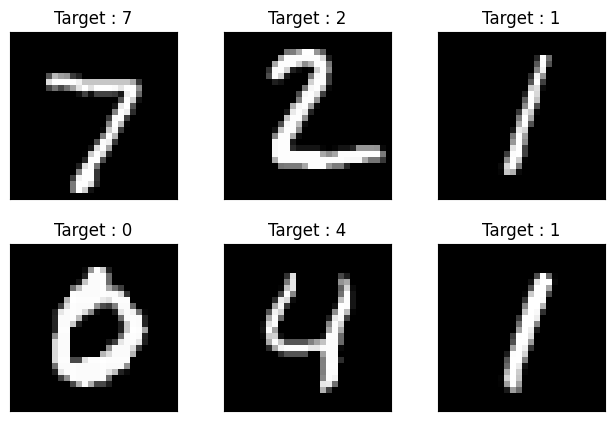

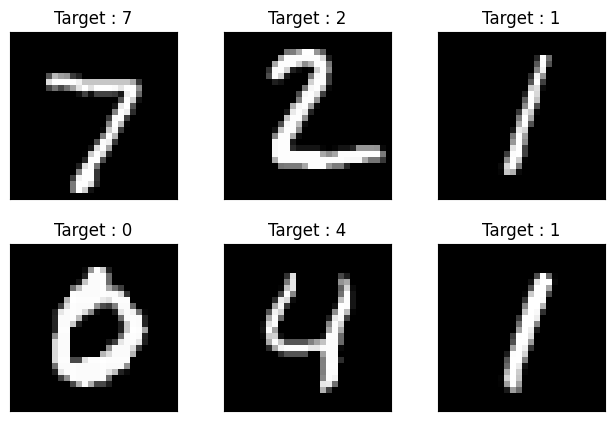

In [ ]:
(images, targets) = next(iter(test_loader))
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap = 'gray', interpolation = 'none')
  plt.title("Target : {}".format(targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 7 * 7)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = CNN()

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for first conv layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for second conv layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization for third conv layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Adjusted for new layer sizes
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the final output
        x = self.fc2(x)
        return x

# Instantiate the improved model
model = ImprovedCNN()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the GPU if available
model = ImprovedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to GPU if available
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print('Finished Training')

Accuracy of the model on the test images: 99.41%


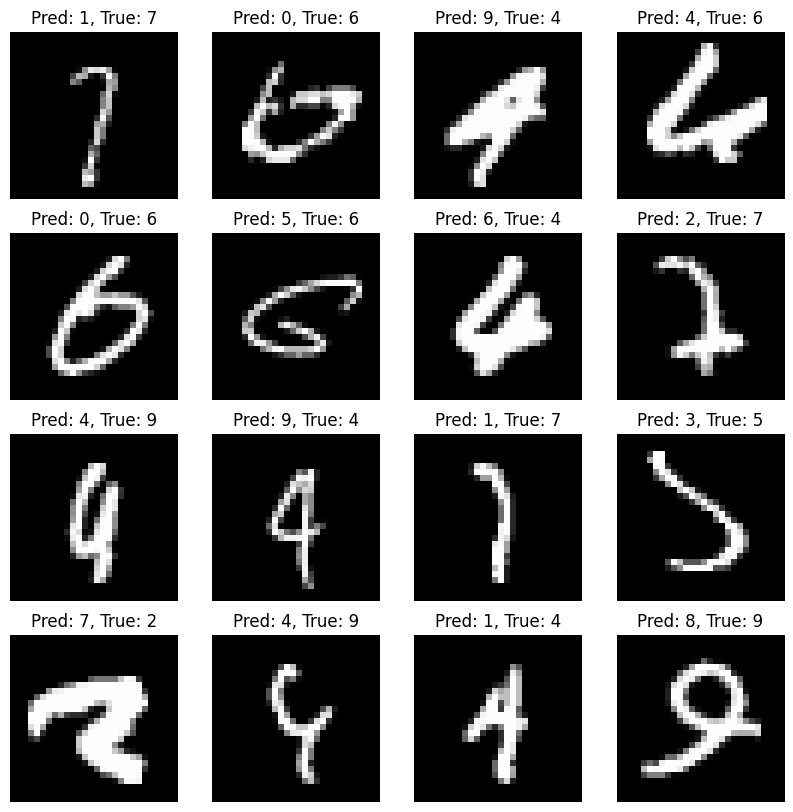

In [ ]:
import matplotlib.pyplot as plt
import torch

# Ensure the model is on the correct device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the GPU if available

model.eval()
correct = 0
total = 0
incorrect_images = []
incorrect_labels = []
incorrect_preds = []

with torch.no_grad():
    for data, target in test_loader:
        # Move data and target to the GPU if available
        data, target = data.to(device), target.to(device)

        # Forward pass
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Store incorrect predictions
        for i in range(len(target)):
            if predicted[i] != target[i]:
                incorrect_images.append(data[i].cpu().squeeze().numpy())  # Store the image, move it to CPU
                incorrect_labels.append(target[i].item())  # Store the correct label
                incorrect_preds.append(predicted[i].item())  # Store the predicted label

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# Visualize some of the incorrect images
fig = plt.figure(figsize=(10, 10))
for i in range(min(len(incorrect_images), 16)):  # Show up to 16 images
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(incorrect_images[i], cmap='gray', interpolation='none')
    ax.set_title(f"Pred: {incorrect_preds[i]}, True: {incorrect_labels[i]}")
    ax.axis('off')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'mnist_cnn.pth')

In [ ]:
len(incorrect_images)

59